# Data Loading

the logs of a single search run for the following search query are analysed:
```
{"baseAssetSymbol":"USDT","minimumVolume":"0","exchanges":["OKEx","HuobiPro","Binance","gateio","cryptopia"]}
```

the logs contain messages mostly of the following format
```
{"level":20,"time":1542643631633,"msg":"evaluated orderbook","pid":36177,"hostname":"Aleksass-MBP","name":"asset-graph-api","name":"AssetGraphController","tickerRate":0.9815517256400504,"orderbookRate":0.9864566929133859,"abHash":"USDT-DADI","bc":"DADI-BTC","ca":"BTC-USDT","abExchange":"OKEx","bcExchange":"OKEx","caExchange":"cryptopia","v":1}
```

note that it includes tickerRate ( based on our database ticker data at the moment of evaluation) and orderbook rate which is fetched live and evaluated at endownment of 0.001 USDT.

In [120]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

df = pd.read_json('./grepped_and_cleaned.txt', orient="records", lines=True);
df = df.drop(columns=['hostname', 'level', 'name', 'pid', 'v', 'msg'])
df['time'] = pd.to_datetime(df.time, unit='ms')
df = df.set_index('time')
df.describe()

,orderbookRate,tickerRate
count,8277.000000,8277.000000
mean,1.038554,1.041499
std,2.435252,2.414752
min,0.009523,0.009609
25%,0.967912,0.971363
50%,0.989416,0.991602
75%,0.996993,0.998379
max,92.400760,91.642537


In [121]:
df.head(5)

,abExchange,abHash,bc,bcExchange,ca,caExchange,orderbookRate,tickerRate
time,,,,,,,,
2018-11-20 12:26:50.751,Binance,USDT-BTC,BTC-EOS,OKEx,EOS-USDT,Binance,0.997444,0.999528
2018-11-20 12:26:50.751,OKEx,USDT-EOS,EOS-BTC,OKEx,BTC-USDT,Binance,1.000656,0.998486
2018-11-20 12:26:50.751,Binance,USDT-EOS,EOS-BTC,OKEx,BTC-USDT,Binance,1.001370,0.998644
2018-11-20 12:26:50.769,Binance,USDT-BTC,BTC-EOS,HuobiPro,EOS-USDT,OKEx,0.999620,0.999718
2018-11-20 12:26:50.769,Binance,USDT-BTC,BTC-EOS,HuobiPro,EOS-USDT,Binance,0.998669,0.999613


# Search performance



The search took 0 days 00:07:54.179000 to explore 8245 potential cycles.


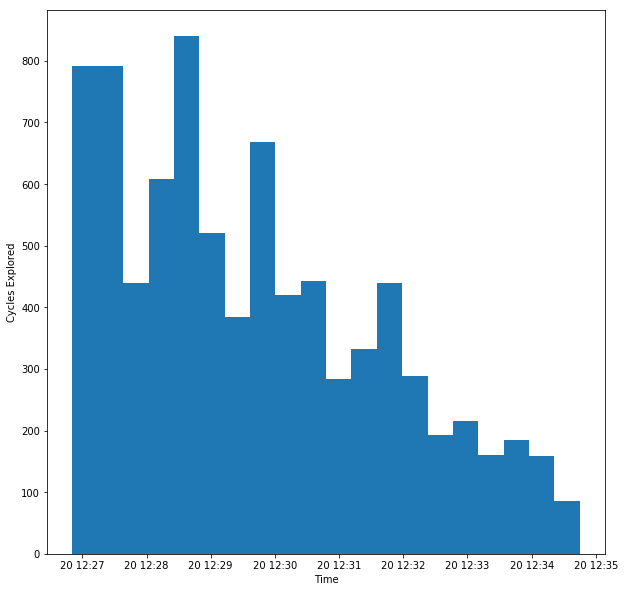

In [129]:
started = df.index.min()
finished = df.index.max()
took = finished - started;
print("The search took", took, "to explore", len(df.index), "potential cycles.")

df.resample('1Min').count()
plt.hist(df.index, bins=20)
plt.xlabel('Time')
plt.ylabel('Cycles Explored')
plt.show()

# Cleaning

We can see that we examined 8245 potential arbitrage cycles. The max rates for both orderbook and ticker based calculations max out at 92 (see summary above), which is due to some cryptos sharing the same symbol on different exchanges. Lets get rid of any potential cycles that have more than 15% gains ( which are unrealistic )

In [144]:
df = df[df['orderbookRate'] < 1.15]
df.describe()

,orderbookRate,tickerRate,absolutePercentageError
count,8245.000000,8245.000000,8245.000000
mean,0.962912,0.966502,0.007806
std,0.086522,0.083385,0.032741
min,0.009523,0.009609,0.000000
25%,0.967736,0.971246,0.000732
50%,0.989268,0.991506,0.001913
75%,0.996946,0.998345,0.005819
max,1.144474,1.143975,0.631844


# Top 25

Lets look at top 25 cycles based on orderbookRate.

In [145]:
df.nlargest(25, 'orderbookRate')

,abExchange,abHash,bc,bcExchange,ca,caExchange,orderbookRate,tickerRate,absolutePercentageError
time,,,,,,,,,
2018-11-20 12:30:31.246,OKEx,USDT-AAC,AAC-ETH,HuobiPro,ETH-USDT,HuobiPro,1.144474,1.143975,4.361099e-04
2018-11-20 12:30:31.246,OKEx,USDT-AAC,AAC-ETH,HuobiPro,ETH-USDT,OKEx,1.144266,1.143392,7.633310e-04
2018-11-20 12:30:31.246,OKEx,USDT-AAC,AAC-ETH,HuobiPro,ETH-USDT,Binance,1.144058,1.142644,1.236094e-03
2018-11-20 12:27:49.542,cryptopia,USDT-BTC,BTC-ARK,Binance,ARK-USDT,cryptopia,1.138493,1.137047,1.270745e-03
2018-11-20 12:27:49.542,HuobiPro,USDT-BTC,BTC-ARK,Binance,ARK-USDT,cryptopia,1.133169,1.132088,9.539001e-04
2018-11-20 12:27:49.542,Binance,USDT-BTC,BTC-ARK,Binance,ARK-USDT,cryptopia,1.132992,1.132391,5.305183e-04
2018-11-20 12:27:49.542,OKEx,USDT-BTC,BTC-ARK,Binance,ARK-USDT,cryptopia,1.132457,1.131751,6.233366e-04
2018-11-20 12:30:31.246,OKEx,USDT-AAC,AAC-ETH,HuobiPro,ETH-USDT,cryptopia,1.131821,1.133009,1.049362e-03
2018-11-20 12:29:01.493,cryptopia,USDT-ETH,ETH-ARK,Binance,ARK-USDT,cryptopia,1.131185,1.131185,9.755552e-08


We can see that the top of the list is dominated by cycles which contain currencies that cannot be withdrawn or deposited from certain exchanges ( i.e. AAC, ICX, BCH ). 

# Ticker Error

Lets calculate the Mean Absolute Percentage Error between ticker ( the forecast ) and orderbook ( actual ) rates.

In [146]:
df['absolutePercentageError'] = df.apply(lambda row: (abs(row['orderbookRate'] - row['tickerRate'])/row['orderbookRate']),
                                        axis=1)

MAPE = 100 / len(df.index) * df['absolutePercentageError'].sum()
print("mean absolute percentage error:", MAPE, "%")

# np.corrcoef(df.index, df['absolutePercentageError'])

mean absolute percentage error: 0.7806206600579206 %


# Error over time

I suspect that that the longer the search goes on for, the more opportunity for error there exists in the asset-graph-api. 

(remember, tickers come in at 1m intervals, moreover orderbook fetches are cached for 30 seconds and can be reused multiple times in different calculations before they expire)

If this was indeed true, we should be able to see an upward trend in the error on the scatter plot.

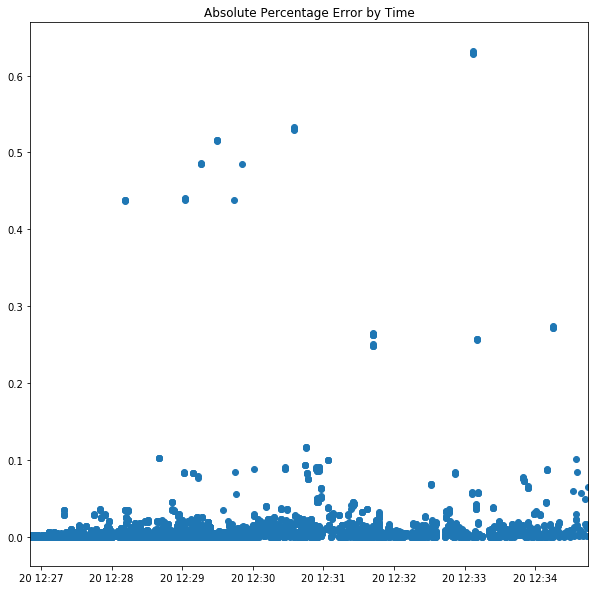

In [151]:
plt.scatter(df.index, df.absolutePercentageError)
plt.title('Absolute Percentage Error by Time')
plt.xlim(started, finished)
plt.show()

We would also expect the order book rates to be somewhat correlated to time, but there can be other factors involved ( i.e. market volatility ), so i'm not sure how good either of those graphs are at testing the hypothesis.

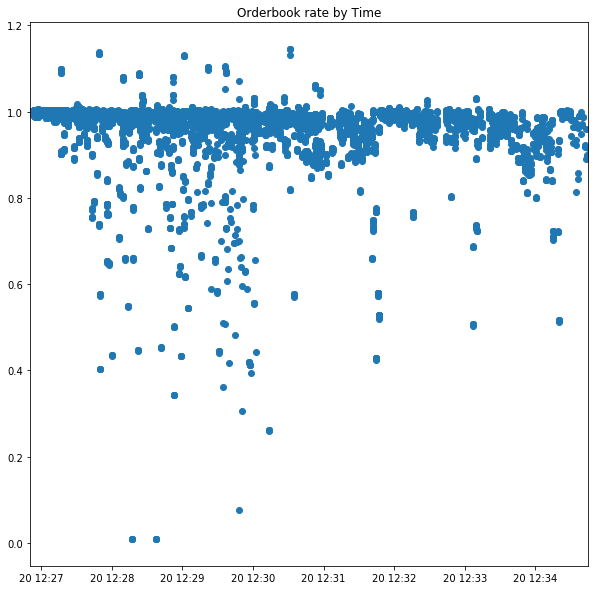

In [155]:
plt.scatter(df.index, df.orderbookRate)
plt.title('Orderbook rate by Time')
plt.xlim(started, finished)
plt.show()

# Profitable cycles

In [156]:
profitable = df[df['orderbookRate'] > 1.006]
print(len(profitable.index), "profitable cycles (above +1.006 on the orderbooks)")

170 profitable cycles (above +1.006 on the orderbooks)


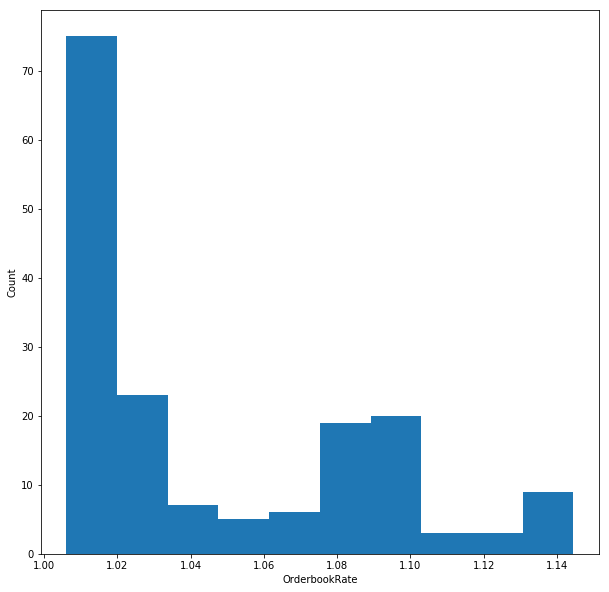

In [157]:

plt.hist(profitable['orderbookRate'])
plt.xlabel('OrderbookRate')
plt.ylabel('Count')
plt.show()